# Predicting Melbourne House Prices
## Phase 2: Statistical Modelling

#### Group Name:

#### Name(s) & ID(s) of Group Members:

#### 

## Table of Contents
- [Introduction](#intro)
    - [Phase 1 Summary](#Ip1sum)
    - [Report Overview](#Iro)
- [Statistical Modelling](#sm)
- [Critique & Limitations](#cl)
- [Summary & Conclusions](#sc)

## Introduction <a id='intro'></a>

### Phase 1 Summary <a id='Ip1sum'></a>

In phase 1 of this assignmnet, we first outlined our goals for this project and took a look at the variables in the dataset. We then looked to clean, process and prepare our dataset on red wine quality which mainly included clamping outlier values for some of the columns. This ensured the data was clean for use in exploring the variables through visualisations with varying numbers of variables and looking for any potential correlations with our target variable. 

### Report Overview <a id='Iro'></a>

A complete and accurate overview of the contents of your Phase 2 report. Clarification: A Table of Contents is not a report overview.

### Overview of Methodology

A detailed, complete, and accurate overview of your statistical modelling methodology (which is multiple linear regression). More specifically, in this subsection, you will provide a summary of your "Statistical Modelling" section below.

## Statistical Modelling <a id='sm'></a>

(Statistical Modelling Section: Details of assumptions check, model selection, plots of residuals, and technical analysis of regression results.)

**NOTE:** The second half of [this](https://github.com/akmand/stats_tutorials/blob/main/regression_case_study_predicting_age_in_census_data.ipynb) regression case study ("Statistical Modeling and Performance Evaluation" Section) will be **very helpful** for this section.

### Full Model Overview

Overview of your full model, including the variables and terms you are using in your model.

#### Module Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None) 

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

df = pd.read_csv('Phase2_Group21.csv', sep=';')

#### Outlier Clamping

In [3]:
outlier_categories = df.columns
outlier_categories = outlier_categories.delete(11) #Remove quality (Target Feature)

for category in outlier_categories:
    q1 = df[category].quantile(0.25)
    q3 = df[category].quantile(0.75)
    iqr = q3 - q1
    bot_out = round(q1 - 1.5*iqr, 2)
    top_out = round(q3 + 1.5*iqr, 2)

    df.loc[df[category] < bot_out, category] = bot_out
    df.loc[df[category] > top_out, category] = top_out

#### Fixing Column Names

Some column names contain spaces which may be problematic when creating the formula string for statsmodel. To be extra safe, we replaced the spaces with underscores.

In [6]:
df.columns = [colname.replace(' ', '_') for colname in list(df.columns)]
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


#### Constructing Formula String

We construct our formula string by using string join of independent variable names seperated by ' + ' which is then joined with the name of our dependent variable separated by ' ~ '.

In [8]:
dep_var = 'quality'
formula_string_indep_vars = ' + '.join(df.drop(columns=dep_var).columns)
formula_string = dep_var + ' ~ ' + formula_string_indep_vars
print('formula_string: ', formula_string)

formula_string:  quality ~ fixed_acidity + volatile_acidity + citric_acid + residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + pH + sulphates + alcohol


#### Linear Regression Full Model

In [10]:
model_full = sm.formula.ols(formula=formula_string, data=df)
model_full_fitted = model_full.fit()
print(model_full_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     84.49
Date:                Wed, 12 Oct 2022   Prob (F-statistic):          3.44e-150
Time:                        21:28:53   Log-Likelihood:                -1558.1
No. Observations:                1599   AIC:                             3140.
Df Residuals:                    1587   BIC:                             3205.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               20.3302 

The full model has an adjusted R-squared value of 0.365, which means that 36.5% of the variation of the dependent variable (quality) is explained by the indepedent variables. By observing the p-values for each feature, we can see that about half of them are significant where their p-value is lower than alpha (0.05).

We will now define a data frame for the actual quality vs predicted quality and residuals for the full model.

In [14]:
residuals_full = pd.DataFrame({'actual': df[dep_var], 
                               'predicted': model_full_fitted.fittedvalues, 
                               'residual': model_full_fitted.resid})
residuals_full.head(10)

,actual,predicted,residual
0,5,5.030193,-0.030193
1,5,5.171483,-0.171483
2,5,5.227244,-0.227244
3,6,5.657863,0.342137
4,5,5.030193,-0.030193
5,5,5.062826,-0.062826
6,5,5.078804,-0.078804
7,7,5.316276,1.683724
8,7,5.346399,1.653601
9,5,5.674847,-0.674847


We will now graph the scatter plot for actual vs predicted quality.

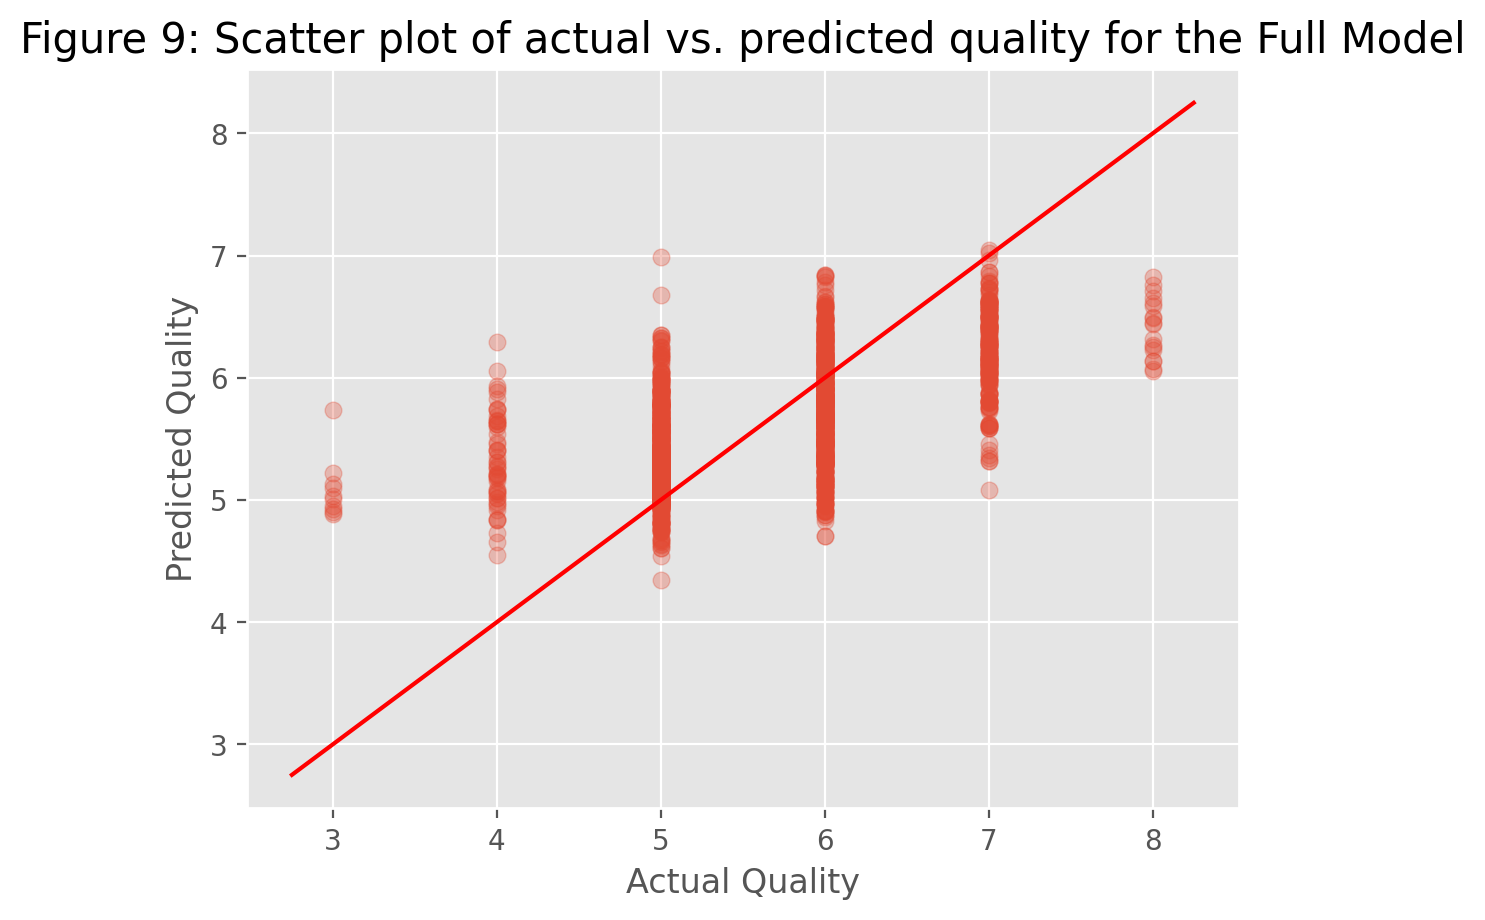

In [17]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)

# Creating scatter plot
plt.scatter(residuals_full['actual'], residuals_full['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual Quality');
plt.ylabel('Predicted Quality');
plt.title('Figure 9: Scatter plot of actual vs. predicted quality for the Full Model', fontsize=15);

### Full Model Diagnostic Checks

You need to check whether there are indications of violations of the regression assumptions for the full model.

### Feature Selection

You can use the code below to to perform backward feature selection using p-values ([credit](https://github.com/akmand/stats_tutorials/blob/main/regression_case_study_predicting_age_in_census_data.ipynb)).

In [35]:
## create the patsy model description from formula
patsy_description = patsy.ModelDesc.from_formula(formula_string_encoded)

# initialize feature-selected fit to full model
linreg_fit = model_full_fitted

# do backwards elimination using p-values
p_val_cutoff = 0.05

## WARNING 1: The code below assumes that the Intercept term is present in the model.
## WARNING 2: It will work only with main effects and two-way interactions, if any.

print('\nPerforming backwards feature selection using p-values:')

while True:

    # uncomment the line below if you would like to see the regression summary
    # in each step:
    ### print(linreg_fit.summary())

    pval_series = linreg_fit.pvalues.drop(labels='Intercept')
    pval_series = pval_series.sort_values(ascending=False)
    term = pval_series.index[0]
    pval = pval_series[0]
    if (pval < p_val_cutoff):
        break
    term_components = term.split(':')
    print(f'\nRemoving term "{term}" with p-value {pval:.4}')
    if (len(term_components) == 1): ## this is a main effect term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0])]))    
    else: ## this is an interaction term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0]), 
                                                        patsy.EvalFactor(term_components[1])]))    
        
    linreg_fit = smf.ols(formula=patsy_description, data=data_encoded).fit()
    
###
## this is the clean fit after backwards elimination
model_reduced_fitted = smf.ols(formula = patsy_description, data = data_encoded).fit()
###
    
#########
print("\n***")
print(model_reduced_fitted.summary())
print("***")
print(f"Regression number of terms: {len(model_reduced_fitted.model.exog_names)}")
print(f"Regression F-distribution p-value: {model_reduced_fitted.f_pvalue:.4f}")
print(f"Regression R-squared: {model_reduced_fitted.rsquared:.4f}")
print(f"Regression Adjusted R-squared: {model_reduced_fitted.rsquared_adj:.4f}")

NameError: name 'formula_string_encoded' is not defined

### Reduced Model Overview

Overview of your reduced model, including the variables and terms you are using in your model.

### Reduced Model Diagnostic Checks

You need to check whether there are indications of violations of the regression assumptions for the reduced model.

## Critique & Limitations <a id='cl'></a>

Critique & Limitations of your approach: strengths and weaknesses in detail.

## Summary & Conclusions <a id='sc'></a>

### Project Summary

A comprehensive summary of your entire project (both Phase 1 and Phase 2). That is, what exactly did you do in your project? (Example: I first cleaned the data in such and such ways. And then I applied multiple linear regression techniques in such and such ways. etc).

### Summary of Findings

A comprehensive summary of your findings. That is, what exactly did you find about your particular problem?

### Conclusions

Your detailed conclusions as they relate to your goals and objectives.